In [91]:
import pandas as pd
import re 
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from textblob import TextBlob
import xgboost
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,id,App Version Code,App Version Name,Review Text,Review Title,Star Rating
0,b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9,NaN,NaN,Very bad wallet balance not use.,NaN,1
1,c7844e8f-56c1-487b-ae3e-df2fdf4c1767,43.0,2.30,Froud app i recharge 199 but not done also sen...,NaN,1
2,93ff57f7-9e02-4fa9-b779-3db82b8af0a4,52.0,2.12,Waste to write comments also,Waste no use,2
3,df2dcdef-c09a-4f35-afab-e1231d3fec9a,62.0,2.21,Nice apo,NaN,5
4,11f8f968-4cec-4424-8427-9709ab05b5be,69.0,2.28,Good nice app,NaN,5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693 entries, 0 to 5692
Data columns (total 6 columns):
id                  5693 non-null object
App Version Code    4554 non-null float64
App Version Name    4554 non-null float64
Review Text         5692 non-null object
Review Title        602 non-null object
Star Rating         5693 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 266.9+ KB


# Dealing with missing data

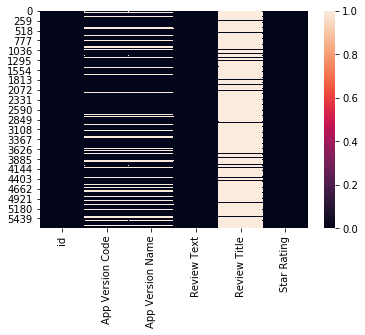

In [50]:
sns.heatmap(data.isnull())

In [51]:
data.isnull().sum()

id                     0
App Version Code    1139
App Version Name    1139
Review Text            1
Review Title        5091
Star Rating            0
dtype: int64

In [52]:
data[data["Review Text"].isnull()]

,id,App Version Code,App Version Name,Review Text,Review Title,Star Rating
1556,e5c14e2d-ab19-48c6-a19f-ed19f21c0851,NaN,NaN,NaN,Fine but not good,3


## Dropping the columns having too much null values or not necessary
Too many null values: "App Version Code","App Version Name","Review Title"
Not necessary: "id:

In [4]:
data.drop(["App Version Code","App Version Name","Review Title", "id"],axis=1,inplace=True)

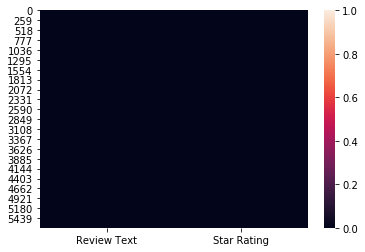

In [4]:
sns.heatmap(data.isnull())

In [5]:
data.isnull().sum()

Review Text    1
Star Rating    0
dtype: int64

## Drop NA values

In [6]:
data.dropna(axis=0,inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
data.isnull().sum()

Review Text    0
Star Rating    0
dtype: int64

In [8]:
data.head()

,Review Text,Star Rating
0,Very bad wallet balance not use.,1
1,Froud app i recharge 199 but not done also sen...,1
2,Waste to write comments also,2
3,Nice apo,5
4,Good nice app,5


# EDA

## Add length field to the data before data cleaning 

In [8]:
data['length'] = data['Review Text'].apply(len)

In [9]:
data.head()

,Review Text,Star Rating,length
0,Very bad wallet balance not use.,1,32
1,Froud app i recharge 199 but not done also sen...,1,77
2,Waste to write comments also,2,28
3,Nice apo,5,8
4,Good nice app,5,13


# Data Visualization
## Check data Distribution

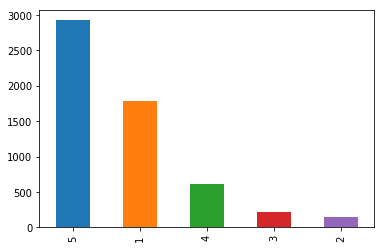

In [11]:
data["Star Rating"].value_counts().plot(kind='bar')

It is highly imbalanced dataset for Ratings 2,3,4
So we will handle it in the following steps using SMOTE upsampling.

## Review Length vs Star Rating

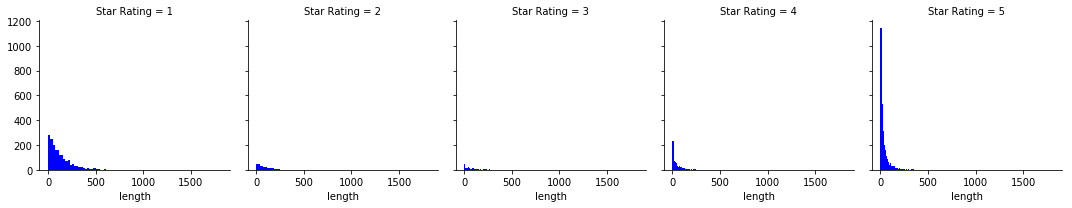

In [11]:
graph = sns.FacetGrid(data=data,col='Star Rating')
graph.map(plt.hist,'length',bins=50,color='blue')

[Text(0, 0.5, 'Density'),
 (-50, 1100),
 Text(0.5, 0, 'Sequence Length'),
 Text(0.5, 1.0, 'Distribution of Sequence Length')]

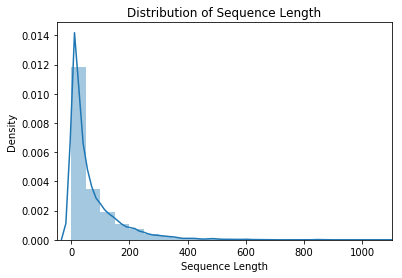

In [13]:
g = sns.distplot(data['length'] , bins=range(0,1100,50))
g.set(xlabel='Sequence Length', ylabel='Density', xlim=[-50,1100], title='Distribution of Sequence Length')

### Rating wise length distribution

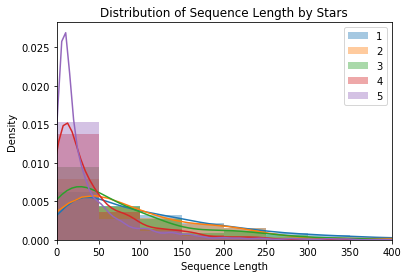

In [15]:
fig, ax = plt.subplots()
for stars in range(1,6):
       g = sns.distplot(data[data["Star Rating"]==stars]["length"], bins=range(0,1100,50), label=str(stars), ax=ax)
g.set(xlabel='Sequence Length', ylabel='Density', title='Distribution of Sequence Length by Stars')

ax.set_xlim([0,400])
g.legend()

## Text Cleaning

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

**Common data cleaning steps on all text:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words

**More data cleaning steps after tokenization:**
* Stemming / lemmatization
* Create bi-grams or tri-grams
* And more...

In [10]:
ps = PorterStemmer()
def clean_data(x):
    review = re.sub('[^a-zA-Z]', ' ' , x)
    review = review.lower()
    review =  review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words("english")]
    review= ' '.join(review)
    return review

In [11]:
data['Review Text'] = data['Review Text'].apply(lambda x: clean_data(x))

## Visualize the Words in each star rating vis Word Cloud

In [19]:
'''
    Function to plot word cloud from a pandas series
    Input: data: pandas.core.series.Series object
    Output: Wordcloud of most recurrent words in data
        for plots to be in ipython notebook include following line before calling this function
        %matplotlib inline '''
def plot_word_cloud(data):
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(str(data))
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Word Cloud for Rating 1


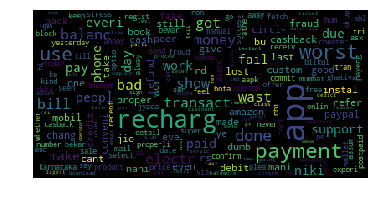

Word Cloud for Rating 2


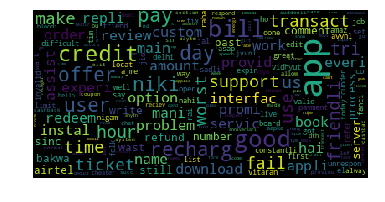

Word Cloud for Rating 3


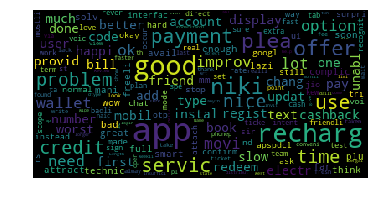

Word Cloud for Rating 4


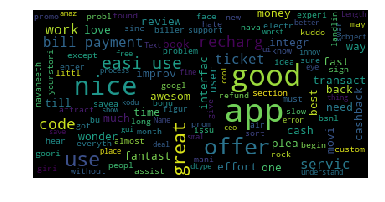

Word Cloud for Rating 5


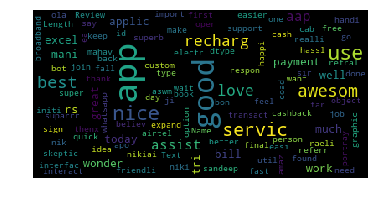

In [20]:
for i in range(1,6):
    print("Word Cloud for Rating {}".format(i))
    plot_word_cloud(data["Review Text"].loc[data["Star Rating"] == i,])

##  Find sentiment of Review Text and add "sentiment" field to data

In [16]:
def find_sentiment(x):
    blob = TextBlob(x)
    feel = blob.sentiment
    if (feel.polarity<0):
        return 1
    elif (feel.polarity==0):
        return 2
    else:
        return 3

In [14]:
data["sentiment"] = data["Review Text"].apply(lambda x: find_sentiment(x))

In [15]:
data.head()

,Review Text,Star Rating,length,sentiment
0,bad wallet balanc use,1,32,1
1,froud app recharg done also send mail niki eve...,1,77,2
2,wast write comment also,2,28,2
3,nice apo,5,8,3
4,good nice app,5,13,3


### Create Document Term Matrix Usinf TF-IDF approach
Using ngram = (1,2) and max-features= 2000

In [17]:
tfIdf = TfidfVectorizer(max_features=1500, ngram_range=(2,2))#35
X = tfIdf.fit_transform(data["Review Text"])
X =  pd.DataFrame(X.toarray())
X = pd.concat([X, data["length"],data["sentiment"]],axis=1)
Y = data["Star Rating"]

### Check the Cross Validation score by using Multinomial Naive Bayes

In [20]:
classifier = MultinomialNB()
f1 = cross_val_score(classifier, X,Y,cv=10,scoring= "f1_macro")
acc = cross_val_score(classifier, X,Y,cv=10)
print("Mean Accuracy is {}".format(acc.mean()))
print("Mean F1 Score is {}".format(f1.mean()))
print("F1 Values are {}".format(f1))

Mean Accuracy is 0.6990516317367022
Mean F1 Score is 0.302429682919209
F1 Values are [0.29994325 0.31288144 0.29461963 0.30729129 0.30125534 0.29691105
 0.31364036 0.29585717 0.30569193 0.29620537]


## It is because on unbalnaced dataset

In [27]:
from collections import Counter
print(sorted(Counter(Y).items()))

[(1, 1788), (2, 154), (3, 216), (4, 611), (5, 2923)]


# Balancing the data
## Upsampling the data using SMOTE

In [21]:
ros = SMOTE(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, Y)

In [30]:
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(1, 2923), (2, 2923), (3, 2923), (4, 2923), (5, 2923)]


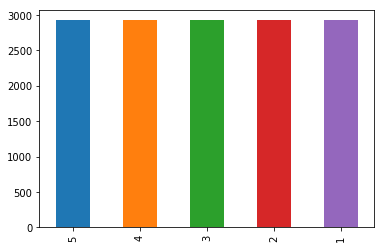

In [22]:
pd.Series(y_resampled).value_counts().plot(kind='bar')

In [44]:
classifier = MultinomialNB()
f1 = cross_val_score(classifier, X_resampled,y_resampled,cv=10,scoring= "f1_macro")
acc = cross_val_score(classifier, X_resampled,y_resampled,cv=10)
print("Mean Accuracy is {}".format(acc.mean()))
print("Mean F1 Score is {}".format(f1.mean()))
print("F1 Values are {}".format(f1))

Mean Accuracy is 0.5961206695030156
Mean F1 Score is 0.5984099128415192
F1 Values are [0.55678984 0.58272119 0.59070303 0.60321831 0.59209412 0.60356256
 0.62256626 0.60979614 0.6113631  0.61128458]


## Note: F1 score almost doubled after balancing the dataset

In [48]:
classifier.fit(X_resampled,y_resampled)
Ypred = classifier.predict(X_resampled)
from sklearn.metrics import confusion_matrix,accuracy_score
Ypred = classifier.predict(X_resampled)
confusion=confusion_matrix(y_resampled,Ypred)

aacuracy_sc=accuracy_score(y_resampled,Ypred)
print(confusion)
from sklearn.metrics import classification_report
print(classification_report(y_resampled,Ypred))

[[2097  599  137   61   29]
 [  31 2782   56   54    0]
 [   5  720 1956  163   79]
 [ 100  958  154 1372  339]
 [  97 1136  114  401 1175]]
              precision    recall  f1-score   support

           1       0.90      0.72      0.80      2923
           2       0.45      0.95      0.61      2923
           3       0.81      0.67      0.73      2923
           4       0.67      0.47      0.55      2923
           5       0.72      0.40      0.52      2923

    accuracy                           0.64     14615
   macro avg       0.71      0.64      0.64     14615
weighted avg       0.71      0.64      0.64     14615



### Check the Cross Validation score by using LogisticRegression

In [41]:
classifier = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
f1 = cross_val_score(classifier, X_resampled,y_resampled,cv=10,scoring= "f1_macro")
acc = cross_val_score(classifier, X_resampled,y_resampled,cv=10)
print("Mean Accuracy is {}".format(acc.mean()))
print("Mean F1 Score is {}".format(f1.mean()))
print("F1 Values are {}".format(f1))

Mean Accuracy is 0.42765650568049
Mean F1 Score is 0.41014132196057246
F1 Values are [0.37044386 0.41576343 0.39994759 0.41070066 0.39968968 0.42365473
 0.43441972 0.41170935 0.43449678 0.40058742]


### Check the Cross Validation score by using Decison tree Classifier

In [45]:
classifier= DecisionTreeClassifier(criterion="entropy")
f1 = cross_val_score(classifier, X_resampled,y_resampled,cv=10,scoring= "f1_macro")
acc = cross_val_score(classifier, X_resampled,y_resampled,cv=10)
print("Mean Accuracy is {}".format(acc.mean()))
print("Mean F1 Score is {}".format(f1.mean()))
print("F1 Values are {}".format(f1))

Mean Accuracy is 0.7737138248632474
Mean F1 Score is 0.7717773240566671
F1 Values are [0.63151277 0.73806986 0.7898339  0.79340819 0.79241444 0.79929482
 0.7936266  0.79569576 0.79259031 0.7913266 ]


### Check the Cross Validation score by using Random Forest Classifier

In [46]:
classifier= RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion="entropy",oob_score=True)
f1 = cross_val_score(classifier, X_resampled,y_resampled,cv=10,scoring= "f1_macro")
acc = cross_val_score(classifier, X_resampled,y_resampled,cv=10)
print("Mean Accuracy is {}".format(acc.mean()))
print("Mean F1 Score is {}".format(f1.mean()))
print("F1 Values are {}".format(f1))

Mean Accuracy is 0.8181153864135771
Mean F1 Score is 0.8188694677612542
F1 Values are [0.71574606 0.78507998 0.82359492 0.82420855 0.83050369 0.82459303
 0.85654237 0.84930541 0.83782078 0.8412999 ]


### Check the Cross Validation score by using KNN Classifier
First find optimal k value

In [47]:
f1=[]
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    fscore = cross_val_score(classifier, X_resampled,y_resampled,cv=10,scoring= "f1_macro")
    f1.append(fscore.mean())

Text(0, 0.5, 'f1 score')

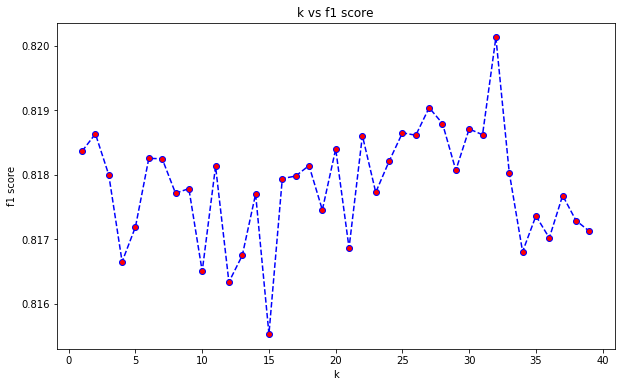

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(1,40),f1,color="blue", linestyle="dashed",marker="o", markerfacecolor="red")
plt.title("k vs f1 score")
plt.xlabel("k")
plt.ylabel("f1 score")

### Choosing k = 33 for best accuracy

In [51]:
knn = KNeighborsClassifier(n_neighbors=33)
f1 = cross_val_score(classifier, X_resampled,y_resampled,cv=5,scoring= "f1_macro")
acc = cross_val_score(classifier, X_resampled,y_resampled,cv=5)
print("Mean Accuracy is {}".format(acc.mean()))
print("Mean F1 Score is {}".format(f1.mean()))
print("F1 Values are {}".format(f1))

Mean Accuracy is 0.8133587401943567
Mean F1 Score is 0.814971353815095
F1 Values are [0.75226275 0.81995121 0.83013597 0.84204585 0.83046099]


### Check the Cross Validation score by usingXGBoost


In [43]:
# classifier = xgboost.XGBClassifier()
# f1 = cross_val_score(classifier, X_resampled,y_resampled,cv=10,scoring= "f1_macro")
# acc = cross_val_score(classifier, X_resampled,y_resampled,cv=10)
# print(acc.mean())
# print(f1.mean())

### Check the Cross Validation score by using SVM Classifier


In [ ]:
classifier = svm.SVC(gamma='scale', decision_function_shape='ovo')
f1 = cross_val_score(classifier, X_resampled,y_resampled,cv=5,scoring= "f1_macro")
acc = cross_val_score(classifier, X_resampled,y_resampled,cv=5)
print("Mean Accuracy is {}".format(acc.mean()))
print("Mean F1 Score is {}".format(f1.mean()))
print("F1 Values are {}".format(f1))

## Fitting the data on Random Forest as it obtains the best F1 score

In [23]:
RFClassifier= RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion="entropy",oob_score=True)
RFClassifier.fit(X_resampled,y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

### Lets have a look at confusion matrix on test split dataset for Random Forest Classifier

In [127]:
xtrain, xtest, ytrain, ytest =  train_test_split (X_resampled,y_resampled,test_size=0.2)
RFClassifierTest= RandomForestClassifier(n_estimators=100, n_jobs = -1, criterion="entropy",oob_score=True)
RFClassifierTest.fit(xtrain,ytrain)
ypred= RFClassifierTest.predict(xtest)
confusion=confusion_matrix(ytest,ypred)

aacuracy_sc=accuracy_score(ytest,ypred)
print("Confusion Matrix \n {}".format(confusion))
print("Classification Report \n {}".format(classification_report(ytest,ypred)))

Confusion Matrix 
 [[508  16  10  12  34]
 [  9 531  11   9   4]
 [  7   9 503  45  23]
 [ 15   8  19 459 112]
 [ 55   4  12 126 382]]
Classification Report 
               precision    recall  f1-score   support

           1       0.86      0.88      0.87       580
           2       0.93      0.94      0.94       564
           3       0.91      0.86      0.88       587
           4       0.71      0.75      0.73       613
           5       0.69      0.66      0.67       579

    accuracy                           0.82      2923
   macro avg       0.82      0.82      0.82      2923
weighted avg       0.82      0.82      0.82      2923



## Plot ROC graph

In [142]:
ynewtest = pd.get_dummies(ytest)

In [129]:
ypred= RFClassifierTest.predict_proba(xtest)

In [148]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes= 5;
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ynewtest.iloc[:,i], ypred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ynewtest.values.ravel(), ypred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

0.9757240937789748
0.9812067260138475
0.9706526685491588
0.9360465526860307
0.9198434838222899


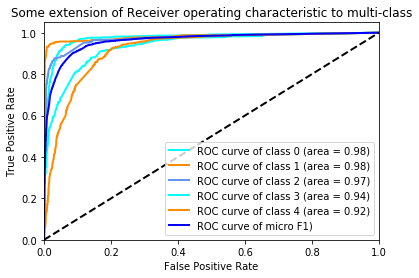

In [151]:
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot(fpr["micro"], tpr["micro"], color="blue", lw=lw,
             label='ROC curve of micro F1)')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Predicting the result for Test Daaset 

In [73]:
test = pd.read_csv("test.csv")

In [74]:
test.head()

,id,App Version Code,App Version Name,Review Text,Review Title
0,bdcb3129-afc1-4608-825f-558fe9c17e2b,78.0,2.37,"Awesome app, all should use it",NaN
1,7518d5c8-5e35-45e2-b29d-cf0996ba9e2f,75.0,2.34,how can i stop notification,NaN
2,b21ca913-ba44-471b-91e1-aaf035379a84,NaN,NaN,"This app is very easy to use , nice graphics ,...",NaN
3,beaaa17d-44af-44c8-ba38-24ba54c3b17d,83.0,2.42,Quite good but felt slow response from cc. Ove...,NaN
4,89d8c4f0-6fe0-4389-b1f8-913ba894c0f1,74.0,2.33,Not getting otp for login since yesterday. Als...,NaN


## Check for null data

In [75]:
test["Review Text"].isnull().sum()

1

In [76]:
test[test["Review Text"].isnull()]

,id,App Version Code,App Version Name,Review Text,Review Title
731,e00bebe4-c8bd-4239-9c6c-93cc364bc84f,NaN,NaN,NaN,Vry helpful


In [77]:
test.fillna(" ", inplace=True)

In [78]:
test["Review Text"].isnull().sum()

0

In [79]:
test["length"] = test['Review Text'].apply(len)

In [80]:
test["sentiment"] = test['Review Text'].apply(lambda x: find_sentiment(x))

In [81]:
test.head()

,id,App Version Code,App Version Name,Review Text,Review Title,length,sentiment
0,bdcb3129-afc1-4608-825f-558fe9c17e2b,78,2.37,"Awesome app, all should use it",,30,3
1,7518d5c8-5e35-45e2-b29d-cf0996ba9e2f,75,2.34,how can i stop notification,,27,2
2,b21ca913-ba44-471b-91e1-aaf035379a84,,,"This app is very easy to use , nice graphics ,...",,85,3
3,beaaa17d-44af-44c8-ba38-24ba54c3b17d,83,2.42,Quite good but felt slow response from cc. Ove...,,62,3
4,89d8c4f0-6fe0-4389-b1f8-913ba894c0f1,74,2.33,Not getting otp for login since yesterday. Als...,,80,2


In [82]:
Xtest = tfIdf.transform(test["Review Text"])

In [83]:
Xtest =  pd.DataFrame(Xtest.toarray())

In [84]:
Xtest = pd.concat([Xtest, test["length"],test["sentiment"]],axis=1)

In [85]:
Xtest.head()

,0,1,2,3,4,5,6,7,8,9,...,1492,1493,1494,1495,1496,1497,1498,1499,length,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80,2


In [86]:
Ypred = RFClassifier.predict(Xtest)

In [87]:
result = pd.DataFrame({"id":test["id"],"Star Rating":Ypred})

In [89]:
result.to_csv("predictions.csv",index=False)